In [1]:
%matplotlib notebook
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hera_cal
from hera_cal import redcal
import hera_sim
import glob, os
import cPickle as cp
import time

In [2]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v

In [3]:
def distance(ant1, ant2, antlocs):
    try: d = np.sqrt((antlocs[ant1][0]-antlocs[ant2][0])**2 + (antlocs[ant1][1]-antlocs[ant2][1])**2)
    except(KeyError): d = 0
    return d

def neighbours(cen_ant, antpos, dist=14.6, antrange=20):
    """Return upto six antennas that neighbour the center antenna"""
    neighbours = []
    for ant in range(cen_ant-antrange, cen_ant+antrange, 1):
        if np.isclose(distance(ant, cen_ant, antpos), dist):
            neighbours.append(ant)
    return neighbours

def gen_reds(redbls):
    """ Given a list of lists of redbls, generate reds
        Input: redbls: list of lists of tuples [[(a0,a1),()],[(),()]]
        Output: reds:  list of lists of tuples [[(a0,a1,'p0p1'),()],[(),()]]
    """
    reds = []
    for subbl in redbls:
        subbl_pol = []
        for pair in subbl:
            subbl_pol.append((pair[0],pair[1],'xx'))
        reds.append(subbl_pol)
    return reds

In [4]:
def plot_ants(antpos):
    for k,v in antpos.items():
        plt.plot(v[0],v[1],'ko')
        plt.annotate('%d'%k,xy=(v[0],v[1]),xytext=(v[0]+.5,v[1]))

def plot_redbl(redbls,color='k'):
    for a1,a2 in redbls:
        plt.plot([antpos[a1][0],antpos[a2][0]],[antpos[a1][1],antpos[a2][1]],'-',color=color)

def plot_redbls_hex(redgrids,color='k'):
    for bls in redgrids:
        plot_redbl(bls,color=color)

def plot_hex(cen_ant):
    idxs = [0, 1, 3, 5, 4, 2]
    neighants = np.asarray(neighbours(cen_ant, antpos))
    if len(neighants) < 6:
        return
    neighants = neighants[idxs]
    for a1,a2 in zip(neighants,np.roll(neighants,1)):
        try: plt.plot([antpos[a1][0], antpos[a2][0]],[antpos[a1][1], antpos[a2][1]],'k-')
        except(KeyError): pass

In [5]:
def genA(redbls):
    # number of parameters = num_ants + num_unique baselines
    N = Nants + len(redbls)
    
    # number of measurements = total number of baselines
    allbls = [bl for red in redbls for bl in red]
    M = len(allbls)
    
    A = np.zeros([M,N],dtype=np.complex)
    i = 0
    for bl,reds in enumerate(redbls):
        for pair in reds:
            A[i,pair[0]] = (1+1j)
            A[i,pair[1]] = (1-1j)
            A[i,Nants+bl] = 1+1j
            i += 1
    return np.matrix(A)

In [ ]:
plt.figure()
plot_ants(antpos)

center_ants = [5,7,16,18,20,29,31]

for a in center_ants:
    plot_hex(a)

In [ ]:
redgrids = []
# Include all the baselines within each small hex
for ant in center_ants:
    subhex = np.append(ant,neighbours(ant,antpos))
    sub_antpos = {k:v for k,v in antpos.items() if k in subhex}
    redgrids.append(hera_cal.redcal.get_pos_reds(sub_antpos))
    
# Include the longer baselines that connect the hexes
subhex_connect = np.array([5, 7, 16, 18, 20, 29, 31])
sub_antpos = {k:v for k,v in antpos.items() if k in subhex_connect}
redgrids.append(hera_cal.redcal.get_pos_reds(sub_antpos))

In [ ]:
redbls = [pair for subgrid in redgrids for pair in subgrid]
#hera_cal.redcal.reds_to_antpos(redbls)

In [ ]:
cmap = matplotlib.cm.get_cmap('Set1')
plt.figure()
for i,bls in enumerate(redgrids):
    plot_redbls_hex(redgrids[i],color=cmap(1.0*i/len(redgrids)))

In [ ]:
A = genA(redbls)

In [ ]:
plt.figure()
plt.imshow(np.abs(A))

In [ ]:
Mr = np.dot(np.real(A.T), np.real(A))
Mi = np.dot(np.imag(np.conjugate(A.T)), np.imag(A))

plt.figure(figsize=(8,4))
plt.subplot(121)
covr = np.linalg.pinv(Mr)[:37,:37]
plt.imshow(np.abs(covr))
plt.colorbar(shrink=0.5)

plt.subplot(122)
covi = -1*np.linalg.pinv(Mi)[:37,:37]
plt.imshow(np.abs(covi))
plt.colorbar(shrink=0.5)

In [ ]:
ant_pairs = [pair for subbl in redbls for pair in subbl]
len(ant_pairs)

In [ ]:
Ur,Sr,Vr = np.linalg.svd(Mr)
Ui,Si,Vi = np.linalg.svd(Mi)

plt.figure()
plt.semilogy(Sr,'o-',label='Real')
plt.semilogy(Si,'o-',label='Imaginary')
plt.legend()
plt.show()

# Honeycomb grouping

In [6]:
center_ants = []
def gen_center_antennas(cen_ant):
    """Return a list of center antennas for a 
    honeycomb radiating from one center antenna"""
    first_layer = neighbours(cen_ant, antpos, dist=25.288, antrange=30)
    flag = 0
    for a1 in first_layer:
        #print a1
        if a1 not in center_ants:
            center_ants.append(a1)
            gen_center_antennas(a1)
        else: flag += 1
    if flag==6:
        return center_ants
    return center_ants

In [7]:
center_ants = []
center_ants = gen_center_antennas(18)
# center_ants = [6, 10, 23, 18, 13, 26, 30]

In [12]:
center_ants

[6, 0, 10, 15, 23, 18, 13, 3, 21, 26, 30, 33, 36]

<IPython.core.display.Javascript object>


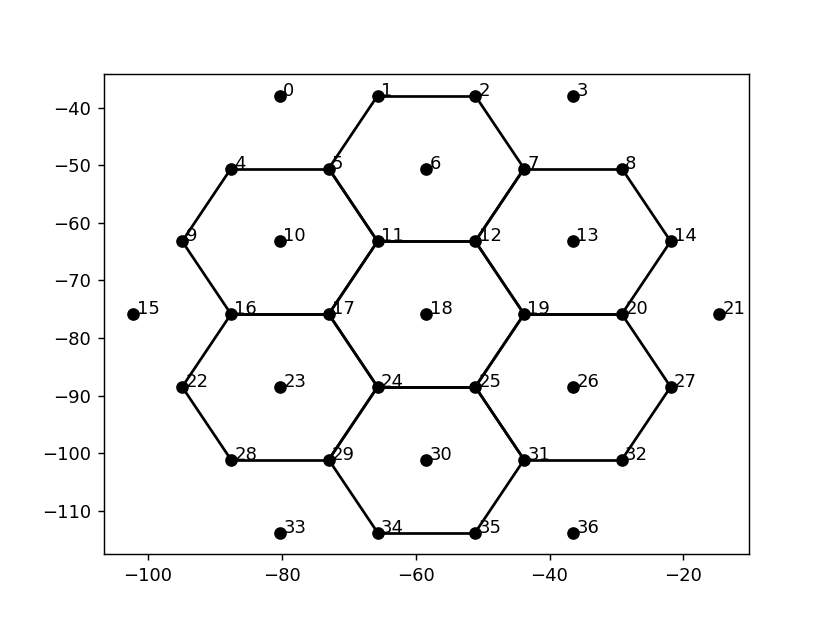

In [8]:
plt.figure()
plot_ants(antpos)
for ant in center_ants:
    plot_hex(ant)

In [18]:
redgrids = []
for ant in center_ants:
    subhex = np.append(ant,neighbours(ant,antpos))
    sub_antpos = {k:v for k,v in antpos.items() if k in subhex}
    redgrids.append(hera_cal.redcal.get_reds(sub_antpos))
    
# Include superhex
superhex = [0, 3, 15, 18, 21, 33, 36]
sub_antpos = {k:v for k,v in antpos.items() if k in superhex}
redgrids.append(hera_cal.redcal.get_reds(sub_antpos))

In [20]:
redbls = [pair for subgrid in redgrids for pair in subgrid]
#hera_cal.redcal.reds_to_antpos(redbls)

<IPython.core.display.Javascript object>


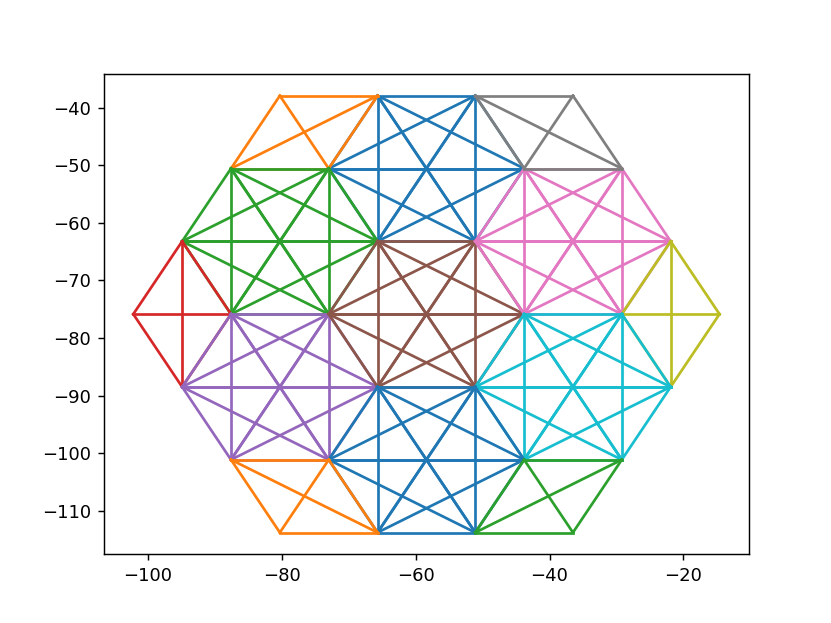

In [11]:
cmap = matplotlib.cm.get_cmap('tab10')
plt.figure()
for i,bls in enumerate(redgrids[:-1]):
    #print i,bls
    plot_redbls_hex(bls,color=cmap(0.1*(i%10)))

In [12]:
A = genA(redbls)

#plt.figure()
#plt.imshow(np.abs(A))

<IPython.core.display.Javascript object>


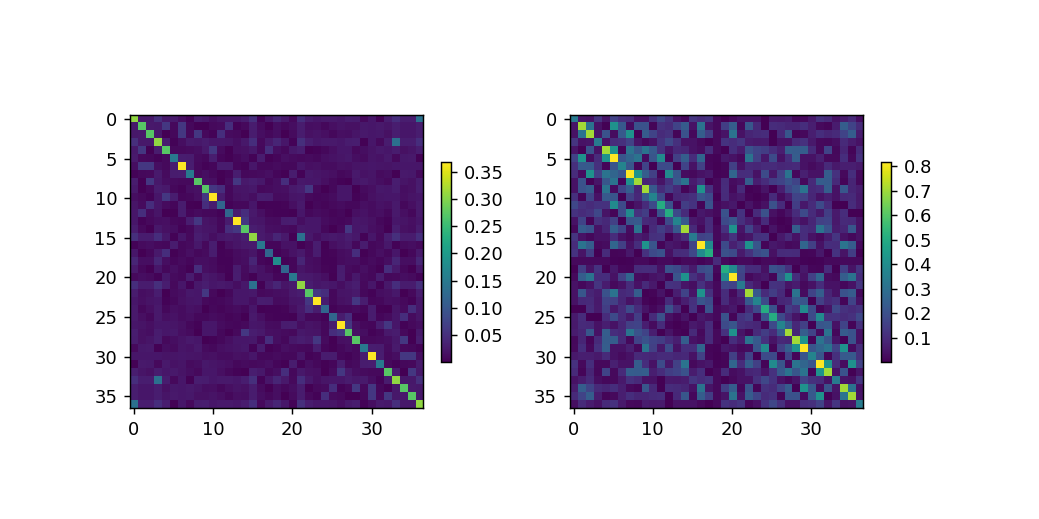

In [13]:
Mr = np.dot(np.real(A.T), np.real(A))
Mi = np.dot(np.imag(np.conjugate(A.T)), np.imag(A))

plt.figure(figsize=(8,4))
plt.subplot(121)
covr = np.linalg.pinv(Mr)[:37,:37]
plt.imshow(np.abs(covr))
plt.colorbar(shrink=0.5)

plt.subplot(122)
covi = -1*np.linalg.pinv(Mi)[:37,:37]
plt.imshow(np.abs(covi))
plt.colorbar(shrink=0.5)

<IPython.core.display.Javascript object>


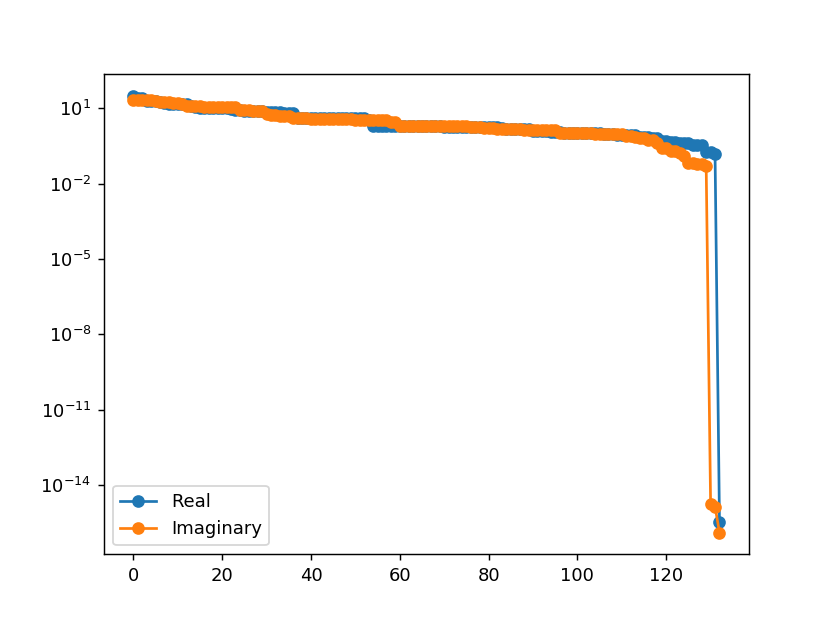

In [14]:
Ur,Sr,Vr = np.linalg.svd(Mr)
Ui,Si,Vi = np.linalg.svd(Mi)

plt.figure()
plt.semilogy(Sr,'o-',label='Real')
plt.semilogy(Si,'o-',label='Imaginary')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


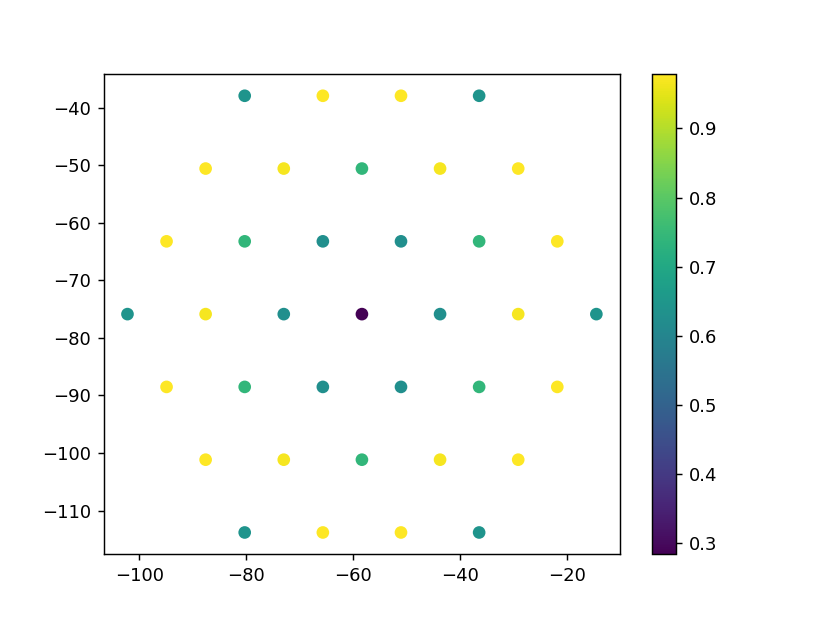

In [15]:
x = [v[0] for v in antpos.values()]
y = [v[1] for v in antpos.values()]

var_sub = np.diag(covr)+np.diag(covi)

plt.figure()
plt.scatter(x,y,c=var_sub)
plt.colorbar()
plt.show()

In [16]:
ant_pairs = [pair for subbl in redbls for pair in subbl]
print "Number of cross-correlations to compute: ",len(ant_pairs)

Number of cross-correlations to compute:  204


In [17]:
reds = gen_reds(redbls)
print "Total number of variables: ",len(reds)+Nants

Total number of variables:  133


In [5]:
print (204 - 133)
print (90 - 40)
print np.sqrt(71/50.)

71
50
1.1916375287812984


In [2]:
print 204/133.
print 90/40.

1.53383458647
2.25


In [18]:
Nsim = 1024
gains_input, vis, data = redcal.sim_red_data(reds,shape=(1,Nsim),gain_scatter=0.1)
data = {k:v+10000*redcal.noise((1,Nsim)) for k,v in data.items()}

redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol = redcalibrator.remove_degen(sol_degen, degen_sol=gains_input)

<IPython.core.display.Javascript object>


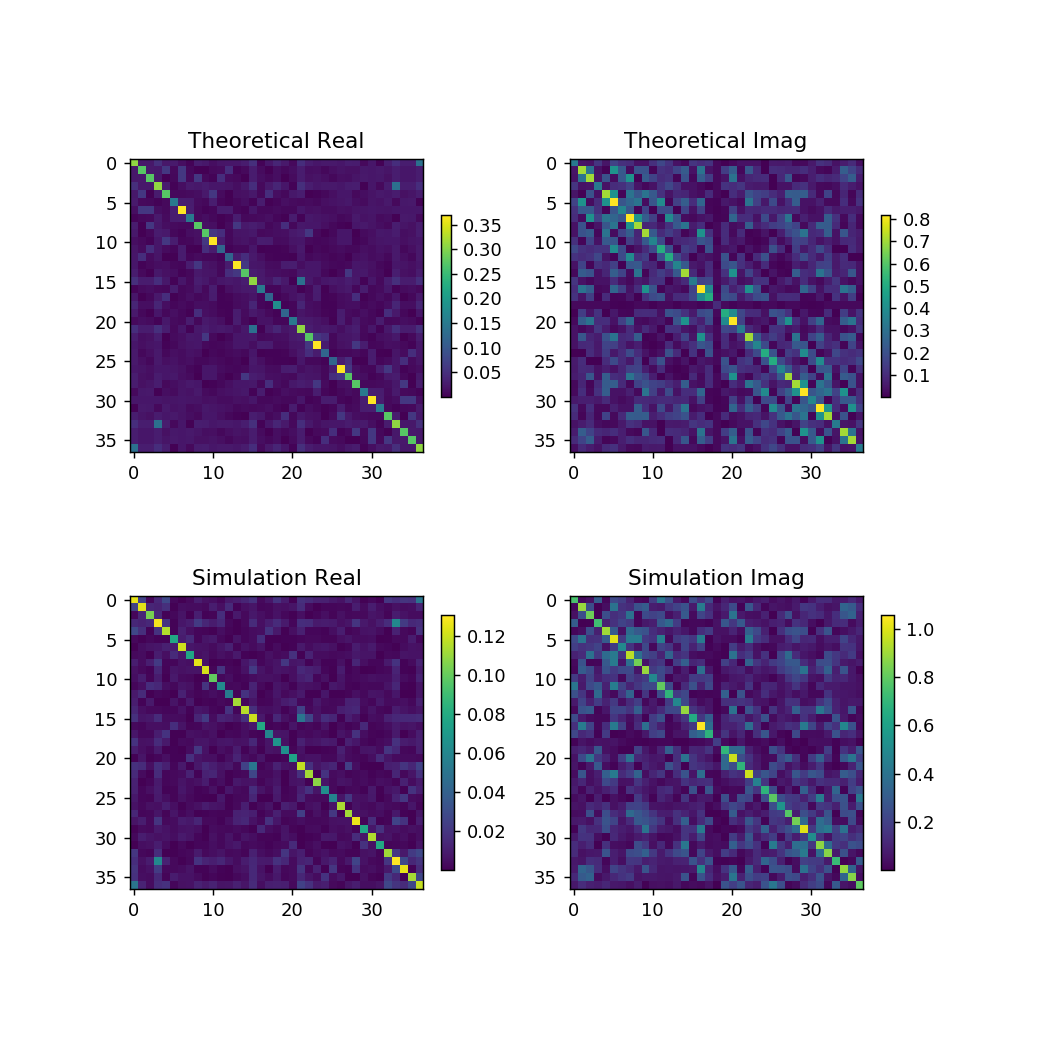

In [19]:
hiergain = []

for ant in range(37):
    hiergain.append(np.log(sol[(ant,'Jxx')][0]))

hiercovr = np.cov(np.real(hiergain))
hiercovi = np.cov(np.imag(hiergain))

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.title('Theoretical Real')
covr = np.linalg.pinv(Mr)[:37,:37]
plt.imshow(np.abs(covr))
plt.colorbar(shrink=0.5)

plt.subplot(222)
plt.title('Theoretical Imag')
covi = -1*np.linalg.pinv(Mi)[:37,:37]
plt.imshow(np.abs(covi))
plt.colorbar(shrink=0.5)

plt.subplot(223)
plt.title('Simulation Real')
plt.imshow(np.abs(hiercovr))
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.title('Simulation Imag')
plt.imshow(np.abs(hiercovi))
plt.colorbar(shrink=0.7)

In [20]:
Nsim = 1024
sigma = 0.1

realreds = redcal.get_reds(antpos)
true_gains, true_vis, data = redcal.sim_red_data(realreds,shape=(1,Nsim),gain_scatter=0.1)
data = {k:v + sigma*redcal.noise((1,Nsim)) for k,v in data.items()}

redcalibrator = redcal.RedundantCalibrator(reds)
sol_degen = redcalibrator.logcal(data)
sol_degen = redcalibrator.lincal(data, sol_degen)
sol = redcalibrator.remove_degen(sol_degen[1], degen_sol=gains_input)

In [78]:
sigma = 0.1

In [69]:
len(sol.keys()) - Nants

96

In [68]:
len(true_vis.keys())

63

In [75]:
def calibrate(data,gains):
    calib_data = {}
    for (i, j, pol) in data.keys():
        calib_data[(i, j, pol)] = data[(i, j, pol)]/(gains[(i,'Jxx')] * np.conj(gains[(j,'Jxx')]))
    return calib_data

def average_red_vis(data, gains, subreds):
    sub_bl_visib = calibrate(data, gains)
    vis = 0
    for subbl in subreds:
        vis += sub_bl_visib[subbl]/len(subreds)
    return vis

model_vis_sub = {}
for k in true_vis.keys():
    subreds = [bls for bls in realreds if k in bls][0]
    model_vis_sub[k] = average_red_vis(data, sol, subreds)

In [79]:
chisq_hier = 0

for k in true_vis.keys():
    subreds = [bls for bls in realreds if k in bls][0] 
    for (i,j,pol) in subreds:
        chisq_hier += np.abs((sol[i,'Jxx']*np.conj(sol[j,'Jxx'])*model_vis_sub[k] -data[(i,j,pol)]))**2

chisq_hier = chisq_hier/((666-100+4)*sigma**2)

print chisq_hier

[[2.69344054 2.33415694 2.64893436 ... 1.76260371 1.88195106 2.12496674]]


In [82]:
Nsim2 = int(np.log(Nsim)/np.log(2))

steps = np.logspace(0, Nsim2, base=2, num=Nsim2+1, dtype=np.int)
chisq_sub = np.zeros([11,Nsim])
model_vis_sub = {}

for n,i in enumerate(steps):
    print i
    # (i) Average the gains
    gain_sub = {}
    for k in true_gains.keys():
        gain_sub[k] = np.asarray([np.repeat(np.mean(sol[k].reshape(-1,i), axis=1), i, axis=0)])

    # (ii) Compute all model visibilities with the averaged gains
    model_vis_sub[n] = {}
    for k in true_vis.keys():
        subreds = [bls for bls in realreds if k in bls][0]
        model_vis_sub[n][k] = average_red_vis(data, gain_sub, subreds) #optimize_red_vis(data, gain_sub, subreds)

    # (iii) Compute the chisq with these new model visibilities
    for k in true_vis.keys():
        subreds = [bls for bls in realreds if k in bls][0] 
        for (a1,a2,pol) in subreds:
            chisq_sub[n] += np.abs((gain_sub[(a1,'Jxx')]*np.conj(gain_sub[(a2,'Jxx')])\
                                    *model_vis_sub[n][k] -data[(a1,a2,pol)])[0])**2
    chisq_sub[n] = chisq_sub[n]/((i*666. - (37+ (63*i)- (4*i)))* sigma**2)

1
2
4
8
16
32
64
128
256
512
1024


<IPython.core.display.Javascript object>


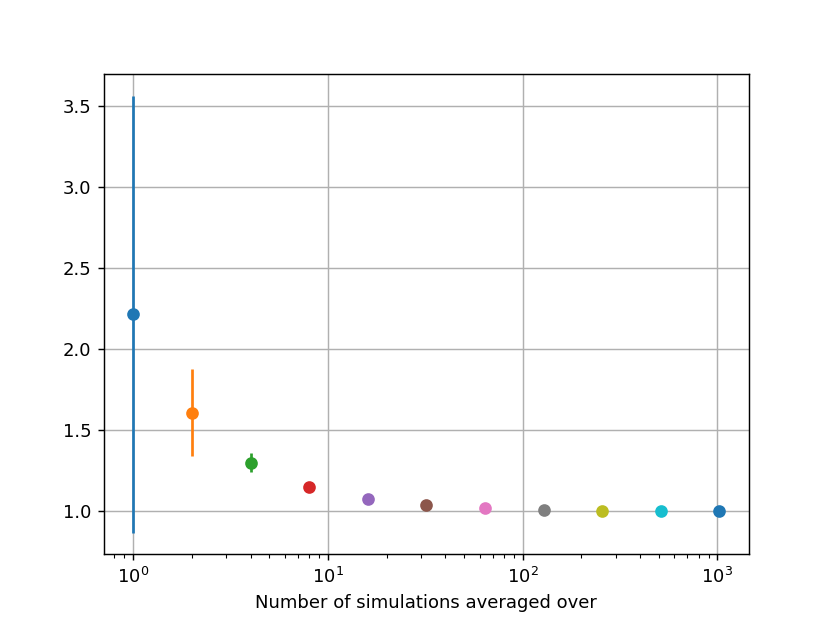

1 2.213867737095386
2 1.605992590468799
4 1.2976732031593337
8 1.1439531660302782
16 1.0713626445649034
32 1.036996677276003
64 1.0173538779500075
128 1.0057189071484465
256 1.0006364793427025
512 0.9980452436190659
1024 0.9972311949880568


Text(0,0.5,'')

In [84]:
plt.figure()
for n,i in enumerate(steps):
    chi = np.mean(np.sum(chisq_sub[n].reshape(-1,i),axis=1))
    print i, chi
    plt.errorbar(i,chi,yerr=np.std(chisq_sub[n]),fmt='o')
#plt.errorbar(1,np.mean(chisq_all[0]),yerr=np.std(chisq_all[0]),fmt='o',color='k')
plt.grid()
plt.semilogx()
plt.xlabel('Number of simulations averaged over')
plt.ylabel('')

In [6]:
2.21 * 1.2

2.6519999999999997

# Larger arrays

In [61]:
Nants = 350

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v

<IPython.core.display.Javascript object>


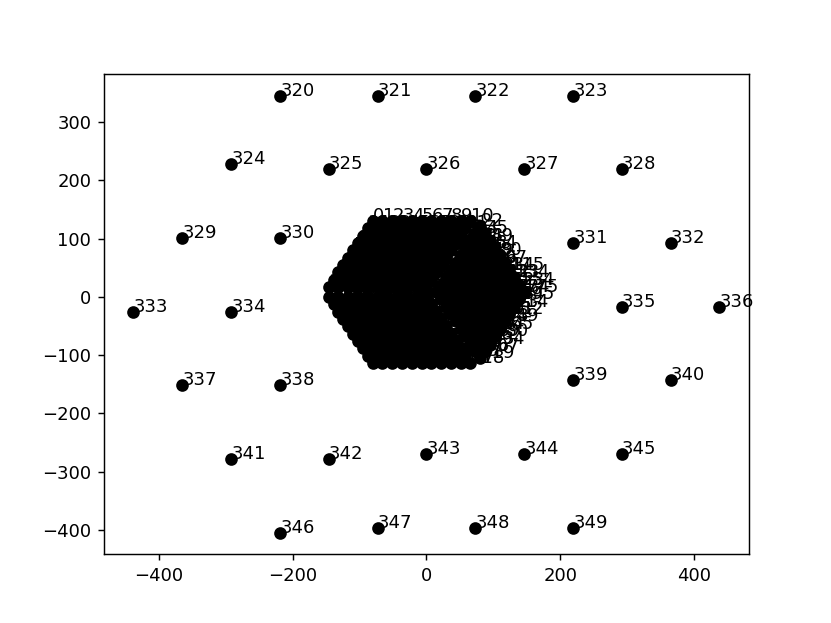

In [62]:
plt.figure()
plot_ants(antpos)

<IPython.core.display.Javascript object>


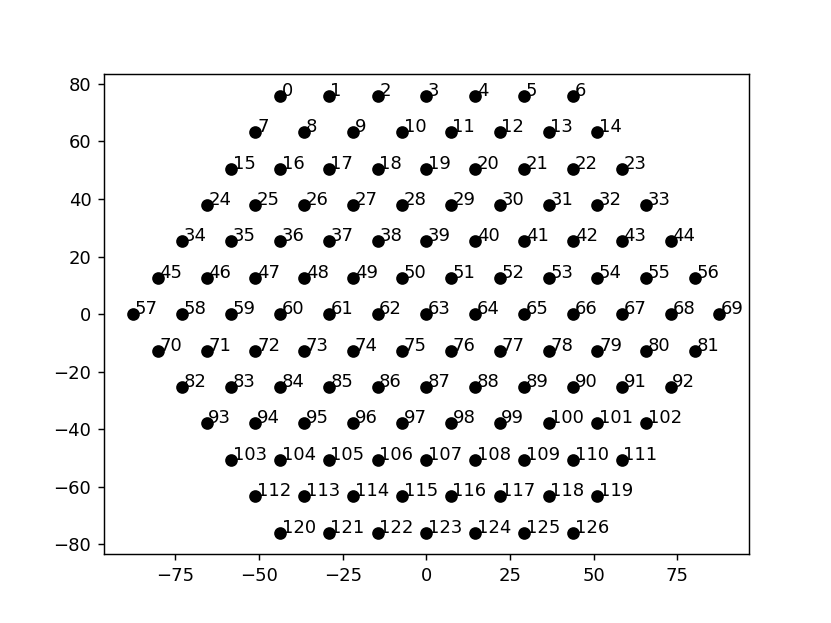

In [63]:
antpos = hera_sim.antpos.hex_array(7,split_core=False,outriggers=0)
plt.figure()
plot_ants(antpos)

In [64]:
center_ants = []
center_ants = gen_center_antennas(63)

<IPython.core.display.Javascript object>


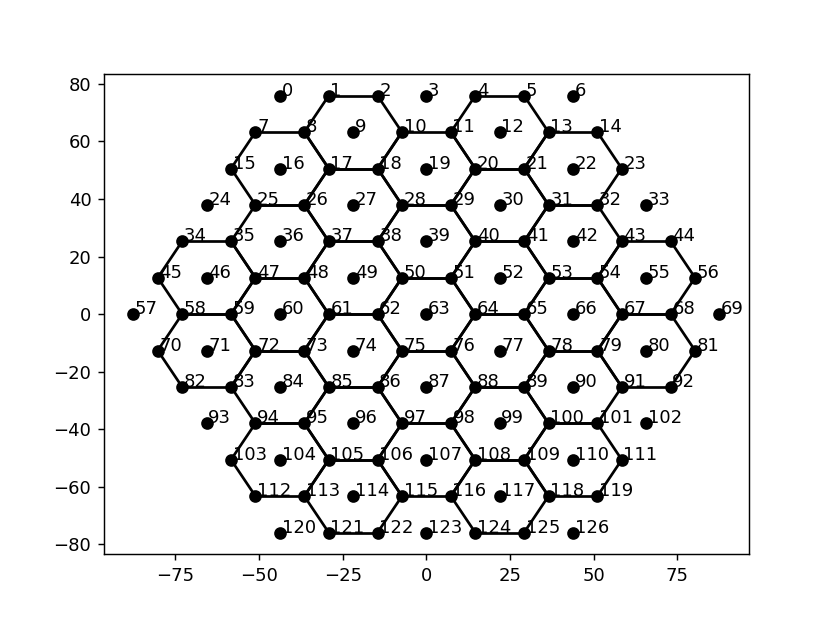

In [65]:
plt.figure()
plot_ants(antpos)
for ant in center_ants:
    plot_hex(ant)